# Choose your ML problems

- 예측모델을 위한 타겟을 올바르게 선택하고 그 분포를 확인할 수 있다.
- 테스트/학습 데이터 사이 or 타겟과 특성들간 일어나는 정보의 누출(leakage)을 피할 수 있다.
- 상황에 맞는 검증 지표(metrics)를 사용할 수 있다. 



- [IAML2.22: Classification accuracy and imbalanced classes](https://www.youtube.com/watch?v=XeJZbCT84Js)
    - 왜 accuracy 만 사용하면 모델 성능에 대해 잘못된 판단을 내릴 수 있을까요?


- 캐글에서 오늘 살펴볼 데이터에 관해 살펴보세요.
    - [Chocolate Bar Ratings](https://www.kaggle.com/rtatman/chocolate-bar-ratings)
    

이번 노트에서는 초컬릿 바 평점 데이터세트를 사용해 머신러닝 문제를 정의해 나가는 과정을 살펴보겠습니다.    

In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/chocolate_bar_ratings/flavors_of_cacao.csv')

### 데이터 과학자 실무 프로세스

실무에서 데이터과학자와 분석가들은 다음과 같은 프로세스를 거치며 프로젝트를 진행하게 됩니다.

1. 비즈니스 문제
    - 실무자들과 대화를 통해 문제를 발견
2. 데이터 문제
    - 문제와 관련된 데이터를 발견
3. 데이터 문제 해결
    - 데이터 처리, 시각화
    - 머신러닝/통계
4. 비즈니스 문제 해결
    - 데이터 문제 해결을 통해 실무자들과 함께 해결

지금까지는 예측 모델을 만들면서 데이터 문제를 확인하고 해결 부분에 집중해 왔습니다. 이 문제들은 여러 비즈니스 문제들을 통해서 나온 것이지요.

캐글 대회를 수행하는것은 여러 모델을 검증해보며 기술을 익히는데 매우 훌륭한 방법입니다. 하지만 이 과정도 데이터 과학 업무의 한 부분에 지나지 않습니다. 이미 문제를 정의하는 과정은 이미 누군가에 의해 정해져 있었고 우리는 기술적으로 데이터를 통한 문제해결에만 집중해 왔습니다.

이번에는 여러분이 각자 프로젝트를 수행하기 위해 어떤 문제를 풀어야 하는지 부터 고민해 봐야 할 시간입니다.

## 우선 예측 해야 하는 타겟을 명확히 정하고 그 분포를 살펴봐야 합니다
### 지도학습(Supervised learning)에서는 예측할 타겟을 먼저 정합니다.

테이블 형태의 데이터세트인 경우 어떤 특성을 예측타겟으로 할지 먼저 정해야 합니다.

어떤 문제는 회귀/분류문제가 쉽게 구분이 안되는 경우도 있습니다.

- 이산형, 순서형, 범주형 타겟 특성도 **회귀**문제 또는 다중클래스**분류** 문제로도 볼 수 있습니다.
- 회귀, 다중클래스분류 문제들도 **이진분류** 문제로 바꿀 수 있습니다.

In [2]:
df.head()

,Company \n(Maker-if known),Specific Bean Origin\nor Bar Name,REF,Review\nDate,Cocoa\nPercent,Company\nLocation,Rating,Bean\nType,Broad Bean\nOrigin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru


In [3]:
df.columns

Index(['Company \n(Maker-if known)', 'Specific Bean Origin\nor Bar Name',
       'REF', 'Review\nDate', 'Cocoa\nPercent', 'Company\nLocation', 'Rating',
       'Bean\nType', 'Broad Bean\nOrigin'],
      dtype='object')

#### 칼럼명을 정리해줍니다.

In [4]:
df.columns = ['company','specificOrigin','ref','reviewDate','cocoaPercent','companyLocation','rating','beanType','broadOrigin']

#### 결측치가 있는 특성을 확인합니다.

In [5]:
# 결측값이 있는 특성을 찾습니다. 몇 개 안되어 후에 전처리 과정에서 제거 하겠습니다.
[(x, df[x].isnull().sum()) for x in df.columns if df[x].isnull().any()]

[('beanType', 1), ('broadOrigin', 1)]

#### 타겟을 확인합니다. 어떤 특성을 예측해야 할까요?

In [6]:
df.dtypes

company             object
specificOrigin      object
ref                  int64
reviewDate           int64
cocoaPercent        object
companyLocation     object
rating             float64
beanType            object
broadOrigin         object
dtype: object

In [7]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
company,1795,416,Soma,47,NaN,NaN,NaN,NaN,NaN,NaN,NaN
specificOrigin,1795,1039,Madagascar,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ref,1795.0,NaN,NaN,NaN,1035.904735,552.886365,5.0,576.0,1069.0,1502.0,1952.0
reviewDate,1795.0,NaN,NaN,NaN,2012.325348,2.92721,2006.0,2010.0,2013.0,2015.0,2017.0
cocoaPercent,1795,45,70%,672,NaN,NaN,NaN,NaN,NaN,NaN,NaN
companyLocation,1795,60,U.S.A.,764,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,1795.0,NaN,NaN,NaN,3.185933,0.478062,1.0,2.875,3.25,3.5,5.0
beanType,1794,41,,887,NaN,NaN,NaN,NaN,NaN,NaN,NaN
broadOrigin,1794,100,Venezuela,214,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### rating이 타겟특성인데 실수형 입니다.

In [8]:
df['rating'].describe()

count    1795.000000
mean        3.185933
std         0.478062
min         1.000000
25%         2.875000
50%         3.250000
75%         3.500000
max         5.000000
Name: rating, dtype: float64

#### 분포를 확인해 보겠습니다.

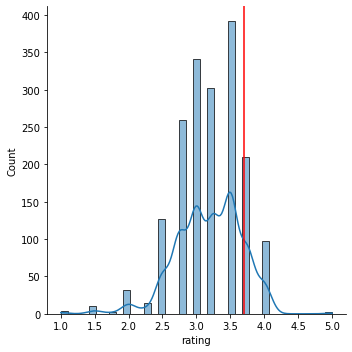

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(df['rating'],kde=True);
plt.axvline(3.7, color='red');

#### rating 이진타입으로 변형시켜 분류문제로 바꾸겠습니다.

In [11]:
## recommend 특성을 만들어 이진분류문제로 변환합니다
df['recommend'] = df['rating'] >= 3.7
df['recommend'].nunique()

2

In [12]:
df['recommend'].value_counts()

False    1485
True      310
Name: recommend, dtype: int64

### 데이터 특성들을 살펴보고 간단하게 전처리 하겠습니다.

In [13]:
df['cocoaPercent'].head()

0    63%
1    70%
2    70%
3    70%
4    70%
Name: cocoaPercent, dtype: object

In [14]:
df['broadOrigin'].unique()

array(['Sao Tome', 'Togo', 'Peru', 'Venezuela', 'Cuba', 'Panama',
       'Madagascar', 'Brazil', 'Ecuador', 'Colombia', 'Burma',
       'Papua New Guinea', 'Bolivia', 'Fiji', 'Mexico', 'Indonesia',
       'Trinidad', 'Vietnam', 'Nicaragua', 'Tanzania',
       'Dominican Republic', 'Ghana', 'Belize', '\xa0', 'Jamaica',
       'Grenada', 'Guatemala', 'Honduras', 'Costa Rica',
       'Domincan Republic', 'Haiti', 'Congo', 'Philippines', 'Malaysia',
       'Dominican Rep., Bali', 'Venez,Africa,Brasil,Peru,Mex', 'Gabon',
       'Ivory Coast', 'Carribean', 'Sri Lanka', 'Puerto Rico', 'Uganda',
       'Martinique', 'Sao Tome & Principe', 'Vanuatu', 'Australia',
       'Liberia', 'Ecuador, Costa Rica', 'West Africa', 'Hawaii',
       'St. Lucia', 'Cost Rica, Ven', 'Peru, Madagascar',
       'Venezuela, Trinidad', 'Trinidad, Tobago',
       'Ven, Trinidad, Ecuador', 'South America, Africa', 'India',
       'Africa, Carribean, C. Am.', 'Tobago', 'Ven., Indonesia, Ecuad.',
       'Trinidad-Tobago

In [15]:
import re

# broadOrigin 텍스트를 수정하기 위한 함수입니다.
def txt_prep(text):
    replacements = [
        ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
        ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
        ['Mad,|Mad$', 'Madagascar, '],
        ['PNG', 'Papua New Guinea, '],
        ['Guat,|Guat$', 'Guatemala, '],
        ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
        ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
        ['Nic,|Nic$', 'Nicaragua, '],
        ['Cost Rica', 'Costa Rica'],
        ['Mex,|Mex$', 'Mexico, '],
        ['Jam,|Jam$', 'Jamaica, '],
        ['Haw,|Haw$', 'Hawaii, '],
        ['Gre,|Gre$', 'Grenada, '],
        ['Tri,|Tri$', 'Trinidad, '],
        ['C Am', 'Central America'],
        ['S America', 'South America'],
        [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
        ['\.',''],
        [' Bali', ',Bali']
    ]
    for i, j in replacements:
        text = re.sub(i, j, text)
    return text

In [16]:
# 몇가지 간단하게 수정할 수 있는 부분만 전처리 합니다.
def preprocess (df):

    df.dropna(inplace=True)
    
    df['cocoaPercent'] = df['cocoaPercent'].str.replace('%','').astype(float)/100
    
    df['broadOrigin'] = df['broadOrigin'].apply(txt_prep)
    
    df['companyLocation'] = df['companyLocation']\
        .str.replace('Amsterdam', 'Holland')\
        .str.replace('U.K.', 'England')\
        .str.replace('Niacragua', 'Nicaragua')\
        .str.replace('Domincan Republic', 'Dominican Republic')
    
    df['beanType'] = df['beanType'].apply(lambda x : 'Missing' if (x is "\xa0") else x)
    
    df['is_blend'] = np.where(
    np.logical_or(
        np.logical_or(df['specificOrigin'].str.lower().str.contains(',|blend|;'),
                      df['broadOrigin'].str.len() == 1),
        df['broadOrigin'].str.lower().str.contains(',')
    )
    , 1
    , 0
)
    
    return df

df = preprocess(df)

<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-16-9cd7b7603bc3>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
  df['beanType'] = df['beanType'].apply(lambda x : 'Missing' if (x is "\xa0") else x)
<ipython-input-16-9cd7b7603bc3>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df['companyLocation'] = df['companyLocation']\


In [17]:
df['is_blend'].value_counts()

0    1095
1     698
Name: is_blend, dtype: int64

## 정보의 누수(leakage)가 없는지 확인합니다.

여러분들이 아직 데이터에 대해 완전히 이해하고 있지 못할 때, 모델을 만들고 평가를 진행했는데 예측을 100% 가깝게 잘 하는 경우를 종종 보게 될 것입니다!

이때 너무 좋아하시면 안됩니다! 정보의 누수가 존재할 가능성이 매우 큽니다!

여러 특성을 다루다 보면 
1. 타겟변수 외에 예측 시점에 사용할 수 없는 데이터가 포함되어 학습이 이루어 질 경우
2. 훈련데이터와 검증데이터를 완전히 분리하지 못했을 경우

**정보의 누수**가 일어나 과적합을 일으키고 실제 테스트 데이터에서 성능이 급격하게 떨어지는 결과를 확인할 수 있습니다.
- [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/).

우선 데이터를 깨끗하게 정리해야 합니다.

In [18]:
df.isna().sum().sort_values()

company            0
specificOrigin     0
ref                0
reviewDate         0
cocoaPercent       0
companyLocation    0
rating             0
beanType           0
broadOrigin        0
recommend          0
is_blend           0
dtype: int64

In [19]:
df['reviewDate'].value_counts().sort_index()

2006     72
2007     77
2008     93
2009    123
2010    111
2011    164
2012    194
2013    184
2014    247
2015    285
2016    219
2017     24
Name: reviewDate, dtype: int64

#### 데이터를 나누겠습니다. 훈련/검증세트로만 나누겠습니다.

In [20]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(df, test_size=0.2, random_state=2)
train.shape, val.shape

((1434, 11), (359, 11))

여기서 이미 알아차리신 경우도 있겠습니다. 어떤 특성이 데이터 누수 문제가 있을까요?
데이터 누수가 일어난 특성을 제거하지 않으면 어떤 결과를 생길까요?

In [22]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 3.6 MB/s eta 0:00:00


In [23]:
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

target = 'recommend'
features = df.columns.drop([target, 'reviewDate'])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

pipe = make_pipeline(
    OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth=5, random_state=2)
)

pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_val, y_val))

검증 정확도:  1.0


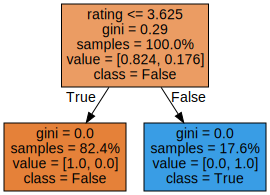

In [24]:
### 어떤 트리가 만들어졌는지 그려봅시다
import graphviz
from sklearn.tree import export_graphviz

tree = pipe.named_steps['decisiontreeclassifier']

dot_data = export_graphviz(
    tree,
    feature_names=X_train.columns, 
    class_names=y_train.unique().astype(str), 
    filled=True, 
    proportion=True
)

graphviz.Source(dot_data)

#### 정보 누수가 일어난 컬럼을 제거해 봅시다.

In [25]:
features = df.columns.drop([target
                            , 'reviewDate'
                            , 'rating'
                            , 'ref'
                           ])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

pipe = make_pipeline(
    OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth=5, random_state=2)
)

pipe.fit(X_train, y_train)
print('검증 정확도', pipe.score(X_val, y_val))

검증 정확도 0.83008356545961


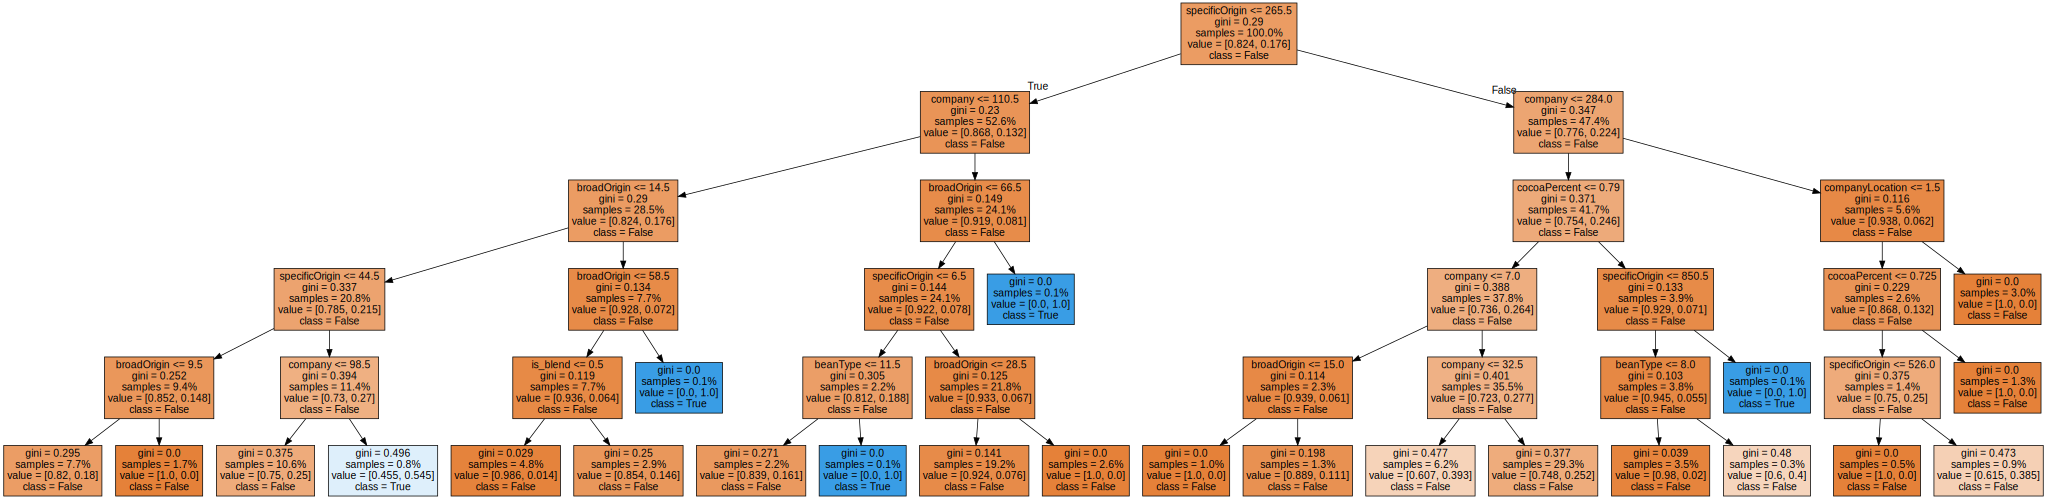

In [26]:
tree = pipe.named_steps['decisiontreeclassifier']

dot_data = export_graphviz(
    tree, 
    feature_names=X_train.columns, 
    class_names=y_train.unique().astype(str), 
    filled=True, 
    proportion=True
)

graphviz.Source(dot_data)

### 문제에 적합한 평가지표를 선택해야 합니다.

여러분이 만든 예측모델을 어떻게 평가해야 할까요? 그것은 문제의 상황에 따라 다를것 입니다.
특히 **분류 & 회귀 모델의 평가지표는 완전히 다릅니다!**

- [Scikit-learn metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
- [분류(classification) metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)
- [회귀(regression) metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)



분류문제에서 타겟 클래스비율이 70% 이상 차이날 경우에는 정확도만 사용하면 판단을 정확히 할 수 없습니다. 

**정밀도, 재현율, ROC curve, AUC** 등을 같이 사용하여야 합니다.

Text(0.5, 1.0, 'Confusion matrix, n = 359')

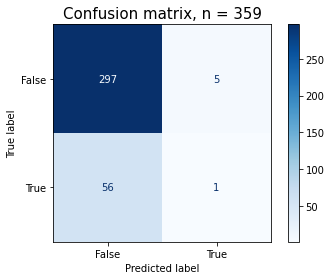

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = ConfusionMatrixDisplay.from_estimator(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)

In [28]:
pipe = make_pipeline(
    OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth=5, random_state=2)
)

pipe.fit(X_train, y_train)
print('검증 정확도', pipe.score(X_val, y_val))

검증 정확도 0.83008356545961


In [29]:
from sklearn.metrics import classification_report
y_pred = pipe.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.84      0.98      0.91       302
        True       0.17      0.02      0.03        57

    accuracy                           0.83       359
   macro avg       0.50      0.50      0.47       359
weighted avg       0.73      0.83      0.77       359



In [30]:
from sklearn.metrics import roc_auc_score

y_pred_proba = pipe.predict_proba(X_val)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))

AUC score:  0.5991634715928895


Text(0, 0.5, 'TPR')

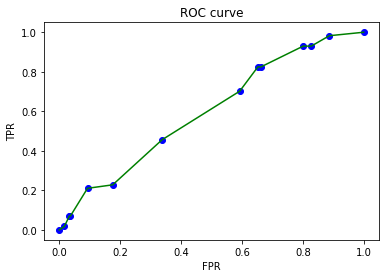

In [31]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

### 불균형 클래스

타겟 특성의 클래스 비율이 차이가 많이 날 경우가 많습니다.

- 대부분 scikit-learn 분류기들은 `class_weight` 와 같은 클래스의 밸런스를 맞추는 파라미터를 가지고 있습니다.
1. 데이터가 적은 범주 데이터의 손실을 계산할 때 가중치를 더 곱하여 데이터의 균형을 맞추거나
2. 적은 범주 데이터를 추가샘플링(oversampling)하거나 반대로 많은 범주 데이터를 적게 샘플링(undersampling)하는 방법이 있습니다.


[Handling Imbalanced Datasets in Deep Learning](https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758)

#### 범주의 비율을 확인합니다.
`class_weight`에서 원하는 비율을 적용하거나 `class_weight='balance'` 옵션을 사용합니다.

In [32]:
y_train.value_counts(normalize=True)

False    0.824268
True     0.175732
Name: recommend, dtype: float64

In [33]:
# class weights 계산
# n_samples / (n_classes * np.bincount(y))
custom = len(y_train)/(2*np.bincount(y_train))
custom

array([0.60659898, 2.8452381 ])

In [34]:
# 파이프라인을 만들어 봅시다.
pipe = make_pipeline(
    OrdinalEncoder(), 
#     DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=2)
    DecisionTreeClassifier(max_depth=5, class_weight={False:custom[0],True:custom[1]}, random_state=2)
)


pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_val, y_val))

검증 정확도:  0.584958217270195


Text(0.5, 1.0, 'Confusion matrix, n = 359')

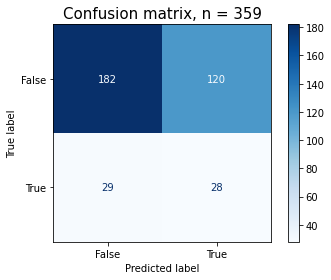

In [36]:
fig, ax = plt.subplots()
pcm = ConfusionMatrixDisplay.from_estimator(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)

#### True 범주의 수치를 비교해 보세요

In [37]:
y_pred = pipe.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.86      0.60      0.71       302
        True       0.19      0.49      0.27        57

    accuracy                           0.58       359
   macro avg       0.53      0.55      0.49       359
weighted avg       0.76      0.58      0.64       359



AUC score:  0.624056000929476


Text(0, 0.5, 'TPR')

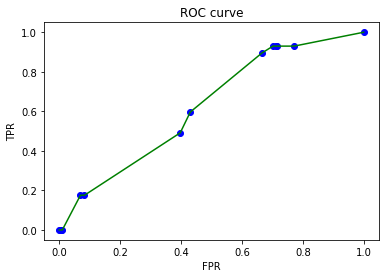

In [38]:
y_pred_proba = pipe.predict_proba(X_val)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

## 회귀문제에서는 타겟의 분포를 주의깊게 살펴보아야 합니다.

In [39]:
# house price 데이터를 사용합니다.
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/house-prices/house_prices_train.csv')

### 타겟을 정합니다
어떤 특성을 예측할 예정입니까?


In [40]:
target = df['SalePrice']

### 타겟의 분포를 살펴봅시다
회귀분석에서는 타겟 분포가 비대칭 형태인지 확인해 보세요.

선형 회귀 모델은 
- 일반적으로 특성과 타겟간에 선형관계를 가정합니다. 
- 그리고 특성 변수들과 타겟변수의 분포가 정규분포 형태일때 좋은 성능을 보입니다. 

특히 타겟변수가 왜곡된 형태의 분포(skewed)일 경우 예측 성능에 부정적인 영향을 미칩니다.

<img src="https://www.researchgate.net/profile/Marco_Faria/publication/294890337/figure/fig5/AS:668873900716049@1536483373457/a-Negative-skewness-b-Normal-curve-c-Positive-skewness-Durkhure-and-Lodwal-2014.ppm" />

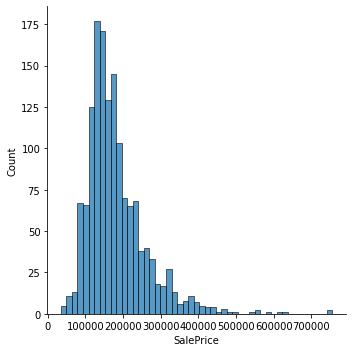

In [41]:
# 타겟 분포가 right(positively) skewed 되어 있네요!
sns.displot(target);

### 이상치가 포함되어 있나요?
이상치를 제거할까요??

In [42]:
## 몇몇 가격이나 다른 수치들은 은 너무 높아 문제가 될 수 있습니다. 
import numpy as np

## 타겟 이상치(outlier)를 제거합니다.
df['SalePrice'] = df[df['SalePrice'] < np.percentile(df['SalePrice'], 99.5)]['SalePrice']

## 몇몇 변수를 합치고 이상치를 제거합니다.
df['All_Flr_SF'] = df['1stFlrSF'] + df['2ndFlrSF']
df['All_Liv_SF'] = df['All_Flr_SF'] + df['LowQualFinSF'] + df['GrLivArea']
df = df.drop(['1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea'], axis=1)

df['All_Flr_SF'] = df[df['All_Flr_SF'] < np.percentile(df['All_Flr_SF'], 99.5)]['All_Flr_SF']
df['All_Liv_SF'] = df[df['All_Liv_SF'] < np.percentile(df['All_Liv_SF'], 99.5)]['All_Liv_SF']


In [43]:
df['SalePrice']

0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
1455    175000.0
1456    210000.0
1457    266500.0
1458    142125.0
1459    147500.0
Name: SalePrice, Length: 1460, dtype: float64

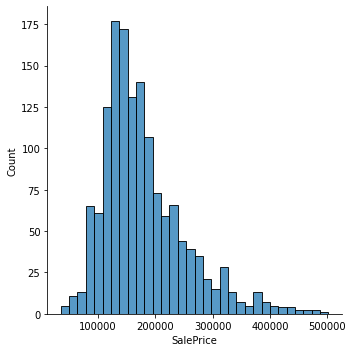

In [44]:
# 분포의 치우침이 어느정도 개선은 되었지만 여전히 right-skewed 상태입니다.
target = df['SalePrice']
sns.displot(target);

### 로그변환(Log-Transform)

타겟이 right-skewed 상태라면 로그변환을 사용해 보세요. 비대칭 분포형태를 정규분포형태로 변환시켜줍니다.

<img src="https://www.researchgate.net/profile/Matthieu_Komorowski4/publication/308022342/figure/fig3/AS:405548043390978@1473701596576/Example-of-the-effect-of-a-log-transformation-on-the-distribution-of-the-dataset.png" width="600" />


- [log1p](https://numpy.org/doc/stable/reference/generated/numpy.log1p.html): `ln(1 + x)`
- [expm1](https://numpy.org/doc/stable/reference/generated/numpy.expm1.html#numpy.expm1): `exp(x) - 1`, the inverse of log1p.

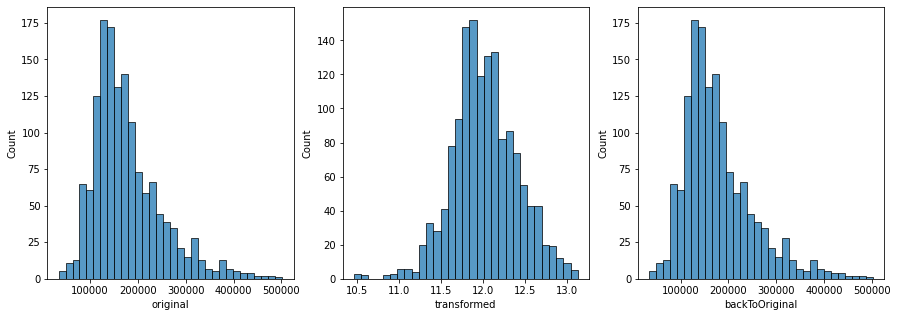

In [45]:
plots=pd.DataFrame()
plots['original']=target
plots['transformed']=np.log1p(target)
plots['backToOriginal']=np.expm1(np.log1p(target))

fig, ax = plt.subplots(1,3,figsize=(15,5))
sns.histplot(plots['original'], ax=ax[0]);
sns.histplot(plots['transformed'], ax=ax[1]);
sns.histplot(plots['backToOriginal'], ax=ax[2]);

#### TransformedTargetRegressor

In [46]:
target = 'SalePrice'
from sklearn.model_selection import train_test_split

df = df[df[target].notna()]

train, val = train_test_split(df, test_size=260, random_state=2)

features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [47]:
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor

pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(),
    RandomForestRegressor(random_state=2)
)


pipe.fit(X_train, y_train)
pipe.score(X_val, y_val)

0.8853294698484703

In [48]:
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor

pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(),
    RandomForestRegressor(random_state=2)
)

tt = TransformedTargetRegressor(regressor=pipe,
                                func=np.log1p, inverse_func=np.expm1)

tt.fit(X_train, y_train)
tt.score(X_val, y_val)

0.8875344733487843

## 참고자료
- [How to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/)
- [Learning from Imbalanced Classes](https://www.svds.com/tbt-learning-imbalanced-classes/)
- [Top 3 Methods for Handling Skewed Data](https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45)
- [Handling Imbalanced Datasets in Deep Learning](https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758)
- [Basic Intuition about Skewness](https://www.kaggle.com/getting-started/176174)